In [ ]:
import dlib
import cv2
import matplotlib.pyplot as plt
import os
from math import atan2, degrees, cos, sin, radians


# Utility function to adjust aspect ratio
def adjust_aspect_ratio(min_x, min_y, max_x, max_y, aspect_ratio):
    width = max_x - min_x
    height = max_y - min_y
    current_aspect_ratio = width / height

    if current_aspect_ratio > aspect_ratio:
        # Adjust height to fit aspect ratio
        new_height = width / aspect_ratio
        diff = new_height - height
        min_y -= diff / 2
        max_y += diff / 2
    else:
        # Adjust width to fit aspect ratio
        new_width = height * aspect_ratio
        diff = new_width - width
        min_x -= diff / 2
        max_x += diff / 2

    return min_x, min_y, max_x, max_y


def rotate_point(point, angle, center):
    x, y = point
    x_c, y_c = center
    angle = radians(angle)  # Convert angle to radians
    x_new = x_c + (x - x_c) * cos(angle) - (y - y_c) * sin(angle)
    y_new = y_c + (x - x_c) * sin(angle) + (y - y_c) * cos(angle)
    return int(x_new), int(y_new)


# Initialize constants
aspect_ratio = 5 / 1  # Example aspect ratio
topBottomPadding = 0
leftRightPadding = 40

# Define the cropping dimensions
crop_width = 1200
crop_height = 400

values = [
    "0002",
    "0004",
    "0006",
    "0009",
    "0014",
    "0018",
    "0020",
    "0024",
    "0029",
    "0031",
    "0035",
    "0040",
    "0044",
    "0047",
    "0049",
    "0052",
    "0054",
    "0003",
    "0005",
    "0007",
    "0013",
    "0015",
    "0019",
    "0021",
    "0027",
    "0030",
    "0033",
    "0038",
    "0042",
    "0045",
    "0048",
    "0051",
    "0053",
    "0056",
]

for value in values:
    # Specify the folder
    folder_path = f"/Users/Owen/Desktop/gaze-project/ColumbiaGazeData/{value}/"
    output_folder_path = f"/Users/Owen/Desktop/gaze-project/Cropped/{value}_cropped/"
    os.makedirs(output_folder_path, exist_ok=True)

    # Initialize dlib's face detector and facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    for i in range(len(os.listdir(folder_path))):
        filename = os.listdir(folder_path)[i]
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Unable to read image at {image_path}")
            continue

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Dlib face detection
        faces = detector(gray)

        for face in faces:
            landmarks = predictor(gray, face)

            # Eye corners
            left_eye_corner = (landmarks.part(36).x, landmarks.part(36).y)
            right_eye_corner = (landmarks.part(45).x, landmarks.part(45).y)

            # Top and bottom of the eye
            left_eye_top = (
                (landmarks.part(37).x + landmarks.part(38).x) // 2,
                (landmarks.part(37).y + landmarks.part(38).y) // 2,
            )
            left_eye_bottom = (
                (landmarks.part(41).x + landmarks.part(40).x) // 2,
                (landmarks.part(41).y + landmarks.part(40).y) // 2,
            )

            right_eye_top = (
                (landmarks.part(43).x + landmarks.part(44).x) // 2,
                (landmarks.part(43).y + landmarks.part(44).y) // 2,
            )
            right_eye_bottom = (
                (landmarks.part(47).x + landmarks.part(46).x) // 2,
                (landmarks.part(47).y + landmarks.part(46).y) // 2,
            )

            # Compute angle between eyes
            dx = right_eye_corner[0] - left_eye_corner[0]
            dy = right_eye_corner[1] - left_eye_corner[1]
            angle = degrees(atan2(dy, dx))

            # Calculate center between the eyes for the rotation
            center = (
                (left_eye_corner[0] + right_eye_corner[0]) // 2,
                (left_eye_corner[1] + right_eye_corner[1]) // 2,
            )

            # Get rotation matrix
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)

            # Perform the rotation
            rotated_image = cv2.warpAffine(
                image, rotation_matrix, (image.shape[1], image.shape[0])
            )

            # Update the eye corner positions post-rotation
            left_eye_corner = rotate_point(left_eye_corner, -angle, center)
            right_eye_corner = rotate_point(right_eye_corner, -angle, center)

            # Update top and bottom eye points after rotation
            left_eye_top = rotate_point(left_eye_top, -angle, center)
            left_eye_bottom = rotate_point(left_eye_bottom, -angle, center)
            right_eye_top = rotate_point(right_eye_top, -angle, center)
            right_eye_bottom = rotate_point(right_eye_bottom, -angle, center)

            # Draw updated eye corners
            # cv2.circle(rotated_image, left_eye_corner, 5, (0, 0, 255), -1)
            # cv2.circle(rotated_image, right_eye_corner, 5, (0, 0, 255), -1)

            # # Draw updated top and bottom of the eye
            # cv2.circle(rotated_image, left_eye_top, 5, (255, 0, 0), -1)
            # cv2.circle(rotated_image, left_eye_bottom, 5, (255, 0, 0), -1)
            # cv2.circle(rotated_image, right_eye_top, 5, (255, 0, 0), -1)
            # cv2.circle(rotated_image, right_eye_bottom, 5, (255, 0, 0), -1)

            # Collect points for cropping (using eye corners and top/bottom points)
            points = [
                left_eye_corner,
                right_eye_corner,
                left_eye_top,
                left_eye_bottom,
                right_eye_top,
                right_eye_bottom,
            ]

            # Calculate minimum and maximum coordinates for cropping
            min_x = min([x for x, y in points]) - leftRightPadding
            max_x = max([x for x, y in points]) + leftRightPadding
            min_y = min([y for x, y in points]) - topBottomPadding
            max_y = max([y for x, y in points]) + topBottomPadding

            # Adjust for aspect ratio
            min_x, min_y, max_x, max_y = adjust_aspect_ratio(
                min_x, min_y, max_x, max_y, aspect_ratio
            )

            # Clip coordinates to avoid going out of image bounds
            min_x = max(0, min_x)
            max_x = min(rotated_image.shape[1], max_x)
            min_y = max(0, min_y)
            max_y = min(rotated_image.shape[0], max_y)

            # Crop the rotated image based on the updated coordinates
            cropped_region = rotated_image[
                int(min_y) : int(max_y), int(min_x) : int(max_x)
            ]
            cropped_region = cv2.resize(cropped_region, (500, 100))

            # Create output path
            output_path = os.path.join(output_folder_path, filename)

            # Save the cropped image
            cv2.imwrite(output_path, cropped_region)

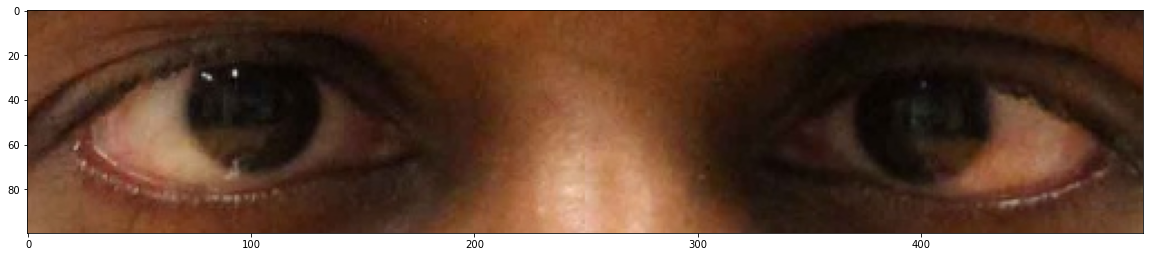

In [ ]:
# Makes cross-eyed images

values = [
    "0003",
    "0002",
    "0009",
    "0013",
    "0014",
    "0018",
    "0019",
    "0020",
    "0021",
    "0024",
    "0027",
    "0029",
    "0030",
    "0031",
    "0035",
    "0038",
    "0042",
    "0044",
    "0048",
    "0049",
    "0051",
    "0054",
    "0056",
]

for value in values:
    output_folder_path = f"/Users/Owen/Desktop/gaze-project/Cropped/{value}_cropped/"

    left_image = f"{value}_2m_0P_0V_-15H.jpg"
    right_image = f"{value}_2m_0P_0V_15H.jpg"

    # Read the left image
    cross_eyed = cv2.imread(os.path.join(output_folder_path, right_image))

    # Read the right image
    right_img = cv2.imread(os.path.join(output_folder_path, left_image))

    # Check if both images are of the same dimensions
    if cross_eyed.shape == right_img.shape:
        # paste right half of the right image on right half of the cross_eyed image
        cross_eyed[:, cross_eyed.shape[1] // 2 :] = right_img[
            :, right_img.shape[1] // 2 :
        ]

        # Convert from BGR to RGB (OpenCV loads images in BGR)
        cross_eyed = cv2.cvtColor(cross_eyed, cv2.COLOR_BGR2RGB)

        # display image
        plt.figure(figsize=(20, 10))
        plt.imshow(cross_eyed)
        plt.show()

        # Missing save logic

    else:
        print("Both images should have the same dimensions.")

In [ ]:
# All people without glasses
# values = [
#     "0002",
#     "0004",
#     "0006",
#     "0009",
#     "0014",
#     "0018",
#     "0020",
#     "0024",
#     "0029",
#     "0031",
#     "0035",
#     "0040",
#     "0044",
#     "0047",
#     "0049",
#     "0052",
#     "0054",
#     "0003",
#     "0005",
#     "0007",
#     "0013",
#     "0015",
#     "0019",
#     "0021",
#     "0027",
#     "0030",
#     "0033",
#     "0038",
#     "0042",
#     "0045",
#     "0048",
#     "0051",
#     "0053",
#     "0056",
# ]